## Evaluation

In [1]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

# imported packages
from lineartree import LinearTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

### Example on continuous only attributes

In [3]:
continuous_only = False

### Read dataframe

In [4]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# simplify dataframe
del df['marital-status']
del df['native-country']
del df['occupation']
del df['relationship']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&()]", "", regex=True)
df = df.replace('[-&()]', '', regex=True)
# missing values imputation with mode (needed for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           48842 non-null  int64 
 1   workclass     48842 non-null  object
 2   education     48842 non-null  object
 3   race          48842 non-null  object
 4   sex           48842 non-null  object
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [5]:
df
df = df.replace(['1st4th', '5th6th', '7th8th', '9th', '10th', '11th', '12th'], ['Firstfourth', 'Fifthsixth', 'Seventheighth', 'Nineth','Tenth', 'Eleventh', 'Twelvths'])

In [6]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = [] if continuous_only else ['race', 'sex', 'workclass']
ordinal_atts = [] if continuous_only else ['education']
continuous_atts = ['age', 'capitalgain', 'hoursperweek'] if continuous_only else ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

In [7]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode_ = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
decode = {
    'education': {
        1:'Preschool', 2:'Firstfourth', 3:'Fifthsixth', 4:'Seventheighth', 5:'Nineth', 6:'Tenth', 7:'Eleventh',
        8:'Twelvths', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,capitalgain,capitalloss,hoursperweek,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,1,0,1,2174,0,40,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,1,0,1,0,0,13,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,1,0,1,0,0,40,0
3,53,0,0,0,1,0,0,0,0,7,...,0,1,0,0,0,1,0,0,40,0
4,28,0,0,0,1,0,0,0,0,13,...,0,1,0,0,1,0,0,0,40,0


In [8]:
# encode-decoding dictionaries
df_code.encode, df_code.decode

({'education': {'Preschool': 1,
   'Firstfourth': 2,
   'Fifthsixth': 3,
   'Seventheighth': 4,
   'Nineth': 5,
   'Tenth': 6,
   'Eleventh': 7,
   'Twelvths': 8,
   'HSgrad': 9,
   'Somecollege': 10,
   'Assocvoc': 11,
   'Assocacdm': 12,
   'Bachelors': 13,
   'Masters': 14,
   'Profschool': 15,
   'Doctorate': 16},
  'class': {'<=50K': 0, '>50K': 1},
  'age': (17, 90),
  'race': {'AmerIndianEskimo': 0,
   'AsianPacIslander': 1,
   'Black': 2,
   'Other': 3,
   'White': 4},
  'workclass': {'Federalgov': 0,
   'Localgov': 1,
   'Neverworked': 2,
   'Private': 3,
   'Selfempinc': 4,
   'Selfempnotinc': 5,
   'Stategov': 6,
   'Withoutpay': 7},
  'sex': {'Female': 0, 'Male': 1},
  'capitalloss': (0, 4356),
  'capitalgain': (0, 99999),
  'hoursperweek': (1, 99)},
 {'education': {1: 'Preschool',
   2: 'Firstfourth',
   3: 'Fifthsixth',
   4: 'Seventheighth',
   5: 'Nineth',
   6: 'Tenth',
   7: 'Eleventh',
   8: 'Twelvths',
   9: 'HSgrad',
   10: 'Somecollege',
   11: 'Assocvoc',
   12: '

In [9]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
#X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)
# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)
X2, XT2, y2, yt2 = train_test_split(X, y, test_size=0.3, random_state=24)
# train a decision tree
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X1, y1)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X2, y2)

DecisionTreeClassifier(max_depth=3)

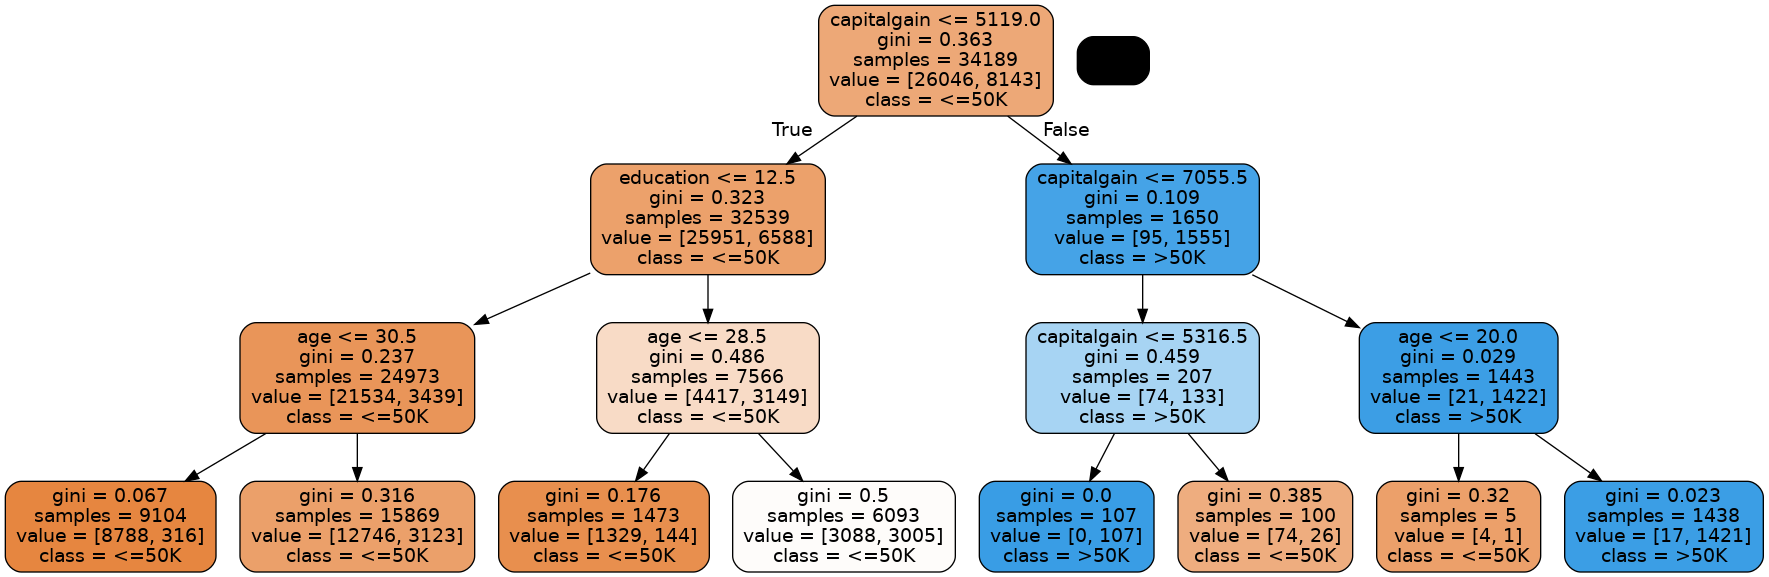

In [10]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [11]:
# basic eval DT
print(clf1.get_depth(), clf1.get_n_leaves(), clf1.score(XT1, yt1))

3 8 0.801610591687709


### Experiment

In [12]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code)
r.model(clf1)

In [13]:
# evaluation list

# 0 - number of solutions factual (must be 1)               single number
# 1 - length of rule factual                                single number
# 2 - number of solutions CE (equals admissible pathes CE)  single number
# 3 - length of rule F/CE                                   2D array
# 4 - number of solutions CE (equals result in 2)           single number
# 5 - distance F - CE                                       1D array/list
# 6 - length of rule F/CE                                   2D array

In [14]:
evaluation_list = []
instances = 100

for i in range(instances):
    evaluation_list_ = []
    # activate the "evaluation", i.e. number of premises in the rule(s) and number of answer constraints
    r.instance('F', features=XT1.iloc[i:i+1], label=yt1.iloc[i])
    a, b, c, d, e = r.solveopt(evaluation = 1)

    # a - number of solutions
    # b - distance (only for opt)
    # c - number of premises in rule
    # c[0] refers to first solution and all rules > here: factual rule
    # d - number of constraints in "answer constraints"
    # e - dimensionality check (only for opt)

    print(a, b, c, d, e)
    evaluation_list_.append(a)
    evaluation_list_.append(np.asarray(c))

    # activate the "evaluation", i.e. number of premises in the rule(s) and number of answer constraints
    r.instance('CF', label=1-yt1.iloc[i])
    a, b, c, d, e = r.solveopt(evaluation= 1)

    # a - number of solutions > here: admissible CF pathes
    # b - distance (only for opt)
    # c - number of premises in rule
    # c[0] refers to first solution and all rules > here: factual and CE rule
    # d - number of constraints in "answer constraints"
    # e - dimensionality check

    print(a, b, c, d, e)
    evaluation_list_.append(a)
    evaluation_list_.append(np.asarray(c))
    
    print("L1 NORM \n")
    a, b, c, d, e = r.solveopt(minimize='l1norm(F, CF)', evaluation=1, eps = 0.01)

    # a - number of solutions
    # b - distance (only for opt)
    # c - number of premises in rule
    # c[0] refers to first solution and all rules > here: factual and CE rule
    # d - number of constraints in "answer constraints"
    # e - dimensionality check

    print(a, b, c, d, e )
    evaluation_list_.append(a)
    evaluation_list_.append(b)
    evaluation_list_.append(np.asarray(c))
    evaluation_list_.append(e)

    evaluation_list.append(evaluation_list_)

    print("Linf NORM \n")
    a, b, c, d, e = r.solveopt(minimize='linfnorm(F, CF)', evaluation=1, eps = 0.01)

    # a - number of solutions
    # b - distance (only for opt)
    # c - number of premises in rule
    # c[0] refers to first solution and all rules > here: factual and CE rule
    # d - number of constraints in "answer constraints"
    # e - dimensionality check

    print(a, b, c, d, e )
    evaluation_list_.append(a)
    evaluation_list_.append(b)
    evaluation_list_.append(np.asarray(c))
    evaluation_list_.append(e)

    evaluation_list.append(evaluation_list_)

    r.reset(keep_model=True)

F.race = White, F.sex = Male, F.workclass = Private, F.education = HSgrad, F.age = 18, F.capitalgain = 0, F.capitalloss = 0, F.hoursperweek = 20
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0
Rule satisfied by F: IF F.capitalgain<=5119.0,F.education<=12.5,F.age<=30.5 THEN <=50K [0.9653]
1.0 [] [[3]] [8] []
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0,CF.capitalgain>5119.0,CF.capitalgain<=5316.5
Rule satisfied by F: IF F.capitalgain<=5119.0,F.education<=12.5,F.age<=30.5 THEN <=50K [0.9653]
Rule satisfied by CF: IF CF.capitalgain>5119.0,CF.capitalgain<=5316.5 THEN >50K [1.0000]
---
Answer constraint: F.race=White,F.sex=Male,F.workclass=Private,F.education=9.0,F.age=18.0,F.capitalgain=0.0,F.capitalloss=0.0,F.hoursperweek=20.0,CF.capitalgain>7055.5,CF.age>20.0
Rule satisfied by F: IF F

### Eval plots

In [15]:
# evaluation list, 0 and 4 can be used to double check that everything went right

# 0 - number of solutions factual (must be 1)               single number
# 1 - length of rule factual                                single number
# 2 - number of solutions CE (equals admissible pathes CE)  single number
# 3 - length of rule F/CE                                   2D array
# L1 NORM
# 4 - number of solutions CE (equals result in 2)           single number
# 5 - distance F - CE                                       1D array/list
# 6 - length of rule F/CE                                   2D array
# 7 - dimensionality
# Linf NORM
# 8 - number of solutions CE (equals results in 2)
# 9 - distance F - CE
# 10 - length of rule F/CE
# 11 - dimensionality


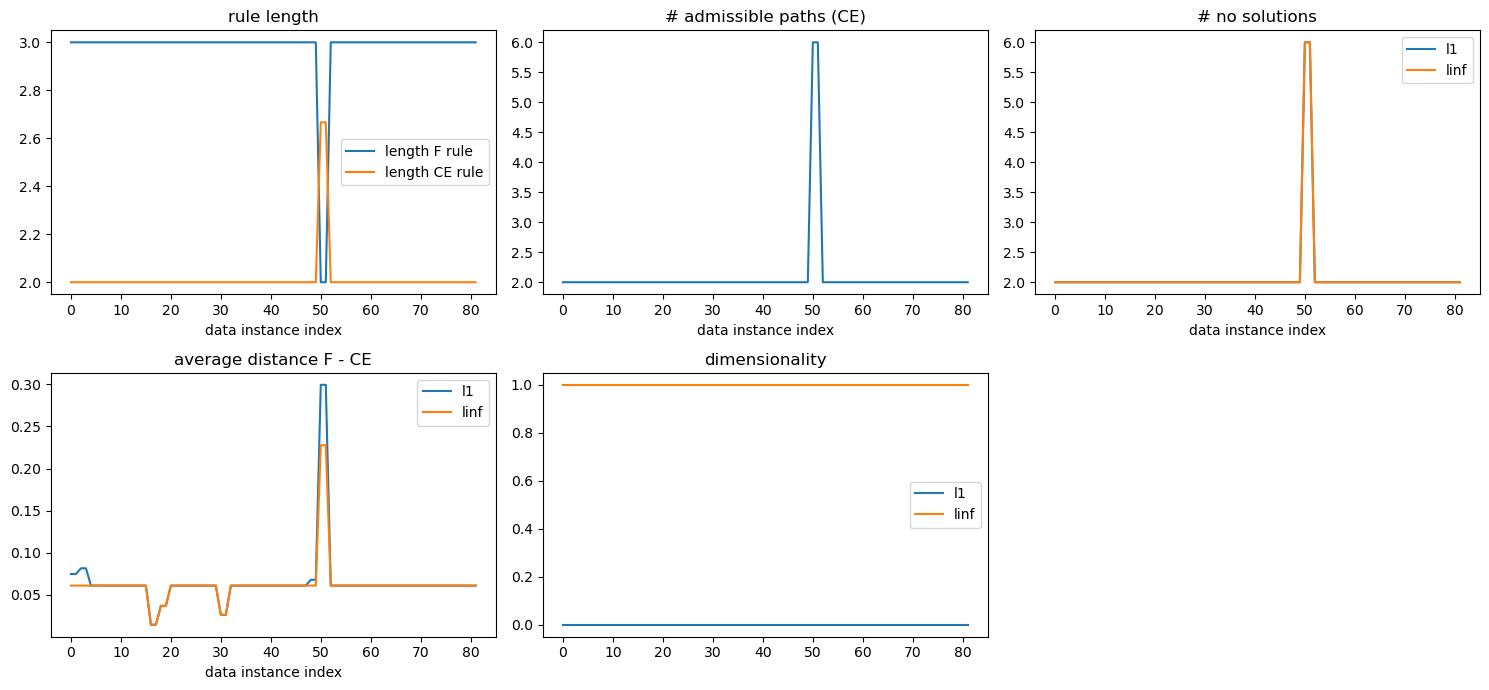

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize= (15, 7))

number_of_solutions_opt_l1 = []
number_of_solutions_opt_linf = []
length_rule_factual = []
length_rule_ce = []
admissible_paths = []
distance_ce_l1 = []
distance_ce_linf = []
dim_l1 = []
dim_linf = []


for j in range(instances):
    if evaluation_list[j][0] == 0:
        continue
    else:
        number_of_solutions_opt_l1.append((evaluation_list[j][4]))
        number_of_solutions_opt_linf.append((evaluation_list[j][8]))
        distance_ce_l1.append(np.mean(evaluation_list[j][5]))
        distance_ce_linf.append(np.mean(evaluation_list[j][9]))
        # sum: if 0 then point if 1 then higher dimension
        dim_l1.append(np.mean((evaluation_list[j][7])))
        dim_linf.append(np.mean((evaluation_list[j][11])))
        
        # from the general query (no opt), position '1' as array contains also length of F rule
        length_rule_ce.append(np.mean(evaluation_list[j][3], axis = 0)[1])
        # from the general query (no opt), single element in array only
        length_rule_factual.append(np.mean(evaluation_list[j][1], axis = 0))
        # from the general query (no opt)
        admissible_paths.append(evaluation_list[j][2])

plt.subplot(2, 3, 1)
plt.plot(length_rule_factual, label = "length F rule")
plt.plot(length_rule_ce, label = "length CE rule")
plt.title("rule length")
plt.xlabel("data instance index")
plt.legend()

#print("lenght F", np.mean(length_rule_factual))
#print("lenght CE", np.mean(length_rule_ce))

plt.subplot(2, 3, 2)
plt.plot(admissible_paths)
plt.title("# admissible paths (CE)")
plt.xlabel("data instance index")

#print("no admissible paths", np.mean(admissible_paths))

plt.subplot(2, 3, 3)
plt.plot(number_of_solutions_opt_l1, label ="l1")
plt.plot(number_of_solutions_opt_linf, label ="linf")
plt.title("# no solutions")
plt.xlabel("data instance index")
plt.legend()

#print("no of solutions", np.mean(number_of_solutions_opt_l1), np.mean(number_of_solutions_opt_linf))

plt.subplot(2, 3, 4)
plt.plot(distance_ce_l1, label = 'l1')
plt.plot(distance_ce_linf, label = 'linf')
plt.title("average distance F - CE")
plt.xlabel("data instance index")
plt.legend()

#print("distance", np.mean(distance_ce_l1), np.mean(distance_ce_linf))

plt.subplot(2, 3, 5)
plt.plot(dim_l1,label ="l1")
plt.plot(dim_linf,label ="linf")
plt.title("dimensionality")
plt.legend()

#print("dimensionality", dim_l1, dim_linf)

plt.tight_layout()
plt.show()